# Clustering locations based on demand

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

## Feature Preparation

We prepare the trips dataframe as in the feature preparation for the station clustering. See notebook `01_cluster_trip_types` for detailed explanation.

In [2]:
trips_df = pd.read_pickle("../00_data/trips.pkl")
trips_hourly_df = pd.read_pickle("../00_data/trips_hourly_selected.pkl")

trips_df["start_time_floored"] = trips_df["start_time"].dt.floor("H")
trips_df = trips_df.sort_values("start_time")
trips_df = trips_df.merge(
    trips_hourly_df, left_on="start_time_floored", right_index=True
)

trips_df["hour_end"] = trips_df["end_time"].dt.hour
trips_df["is_weekday"] = trips_df["is_weekday"].apply(lambda x: int(x))
trips_df["is_holiday"] = trips_df["is_holiday"].apply(lambda x: int(x))

We filter only demand related features from the trips dataframe and save them to `trips_demand_df`.

In [3]:
trips_demand_df = trips_df[
    [
        "start_time",
        "end_time",
        "start_station_id",
        "end_station_id",
        "hour",
        "month",
        "is_weekday",
        "is_holiday",
        "hour_end",
    ]
]
trips_demand_df.head(2)

,start_time,end_time,start_station_id,end_station_id,hour,month,is_weekday,is_holiday,hour_end
210759,2019-01-01 01:29:00,2019-01-01 02:49:00,4211,4211,1,1,1,1,2
210760,2019-01-01 01:31:00,2019-01-01 02:49:00,4211,4211,1,1,1,1,2


Then we create different features from our demand related data:

- Demand at different times in a day

In [4]:
# filter dataframe for different features
morning_df = trips_demand_df[
    (trips_demand_df["hour"] > 4) & (trips_demand_df["hour"] <= 10)
]
noon_df = trips_demand_df[
    (trips_demand_df["hour"] > 10) & (trips_demand_df["hour"] <= 16)
]
evening_df = trips_demand_df[
    (trips_demand_df["hour"] > 16) & (trips_demand_df["hour"] <= 22)
]
night_df = trips_demand_df[
    (trips_demand_df["hour"] > 22) | (trips_demand_df["hour"] <= 4)
]

morning_end_df = trips_demand_df[
    (trips_demand_df["hour_end"] > 4) & (trips_demand_df["hour_end"] <= 10)
]
noon_end_df = trips_demand_df[
    (trips_demand_df["hour_end"] > 10) & (trips_demand_df["hour_end"] <= 16)
]
evening_end_df = trips_demand_df[
    (trips_demand_df["hour_end"] > 16) & (trips_demand_df["hour_end"] <= 22)
]
night_end_df = trips_demand_df[
    (trips_demand_df["hour_end"] > 22) | (trips_demand_df["hour_end"] <= 4)
]

# save time new features to stations
start_all = trips_demand_df.groupby("start_station_id").size()
stations_new_df = pd.DataFrame({"start_all": start_all})
stations_new_df["end_all"] = trips_demand_df.groupby("end_station_id").size()
stations_new_df["fluctuation"] = (
    stations_new_df["end_all"] - stations_new_df["start_all"]
)

stations_new_df["start_morning"] = morning_df.groupby("start_station_id").size()
stations_new_df["start_noon"] = noon_df.groupby("start_station_id").size()
stations_new_df["start_evening"] = evening_df.groupby("start_station_id").size()
stations_new_df["start_night"] = night_df.groupby("start_station_id").size()

stations_new_df["end_morning"] = morning_end_df.groupby("end_station_id").size()
stations_new_df["end_noon"] = noon_end_df.groupby("end_station_id").size()
stations_new_df["end_evening"] = evening_end_df.groupby("end_station_id").size()
stations_new_df["end_night"] = night_end_df.groupby("end_station_id").size()

- Demand in different seasons

In [5]:
# filter dataframe for different features
summer_df = trips_demand_df[
    (trips_demand_df["month"] > 3) & (trips_demand_df["hour"] <= 9)
]
winter_df = trips_demand_df[
    (trips_demand_df["month"] > 9) | (trips_demand_df["hour"] <= 3)
]

# save time new features to stations
stations_new_df["start_summer"] = summer_df.groupby("start_station_id").size()
stations_new_df["end_summer"] = summer_df.groupby("end_station_id").size()
stations_new_df["start_winter"] = winter_df.groupby("start_station_id").size()
stations_new_df["end_winter"] = winter_df.groupby("end_station_id").size()

- Demand on weekends and holidays

In [6]:
# filter dataframe for different features
holiday_df = trips_demand_df[trips_demand_df["is_holiday"] == 1]
weekday_df = trips_demand_df[trips_demand_df["is_weekday"] == 1]
weekend_df = trips_demand_df[trips_demand_df["is_weekday"] == 0]

# save time new features to stations
stations_new_df["start_holiday"] = holiday_df.groupby("start_station_id").size()
stations_new_df["end_holiday"] = holiday_df.groupby("end_station_id").size()
stations_new_df["start_week"] = weekday_df.groupby("start_station_id").size()
stations_new_df["end_week"] = weekday_df.groupby("end_station_id").size()
stations_new_df["start_weekend"] = weekend_df.groupby("start_station_id").size()
stations_new_df["end_weekend"] = weekend_df.groupby("end_station_id").size()

Lastly we fill Null values with the numeric integer 0 and save the location data in a pickle file.

In [7]:
stations_new_df = stations_new_df.fillna(0)
stations_new_df

,start_all,end_all,fluctuation,start_morning,start_noon,start_evening,start_night,end_morning,end_noon,end_evening,...,start_summer,end_summer,start_winter,end_winter,start_holiday,end_holiday,start_week,end_week,start_weekend,end_weekend
start_station_id,,,,,,,,,,,,,,,,,,,,,
3005,12610,13408,798,2289.0,4458.0,5303.0,560.0,3517.0,4846.0,4424,...,1609.0,2489.0,3836.0,4004.0,512.0,570.0,9767,10607,2843.0,2801.0
3006,5959,6177,218,825.0,2338.0,2457.0,339.0,676.0,2604.0,2598,...,555.0,468.0,1599.0,1624.0,285.0,306.0,4303,4452,1656.0,1725.0
3007,4608,4110,-498,472.0,2173.0,1881.0,82.0,1261.0,1831.0,935,...,265.0,935.0,1334.0,1272.0,222.0,168.0,3752,3369,856.0,741.0
3008,3375,3244,-131,390.0,1326.0,1470.0,189.0,744.0,1201.0,1141,...,292.0,522.0,1025.0,982.0,160.0,136.0,2527,2386,848.0,858.0
3010,721,755,34,33.0,351.0,325.0,12.0,186.0,440.0,116,...,23.0,135.0,209.0,193.0,40.0,45.0,594,557,127.0,198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,29,31,2,2.0,15.0,12.0,0.0,2.0,19.0,10,...,0.0,2.0,29.0,31.0,1.0,2.0,20,22,9.0,9.0
4483,43,34,-9,5.0,28.0,6.0,4.0,2.0,22.0,6,...,6.0,4.0,43.0,34.0,4.0,2.0,30,23,13.0,11.0
4490,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1,...,0.0,0.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0


In [8]:
stations_new_df.to_pickle('../00_data/station_demand.pkl')

## Clustering

We read in the pickle file and take a look at our columns and values.

In [9]:
stations_df = pd.read_pickle('../00_data/station_demand.pkl')
stations_df.head(2)

,start_all,end_all,fluctuation,start_morning,start_noon,start_evening,start_night,end_morning,end_noon,end_evening,...,start_summer,end_summer,start_winter,end_winter,start_holiday,end_holiday,start_week,end_week,start_weekend,end_weekend
start_station_id,,,,,,,,,,,,,,,,,,,,,
3005,12610,13408,798,2289.0,4458.0,5303.0,560.0,3517.0,4846.0,4424,...,1609.0,2489.0,3836.0,4004.0,512.0,570.0,9767,10607,2843.0,2801.0
3006,5959,6177,218,825.0,2338.0,2457.0,339.0,676.0,2604.0,2598,...,555.0,468.0,1599.0,1624.0,285.0,306.0,4303,4452,1656.0,1725.0


For a 2D Visualization we create pair plots to maybe see clusters by simply
looking at the pair plots.

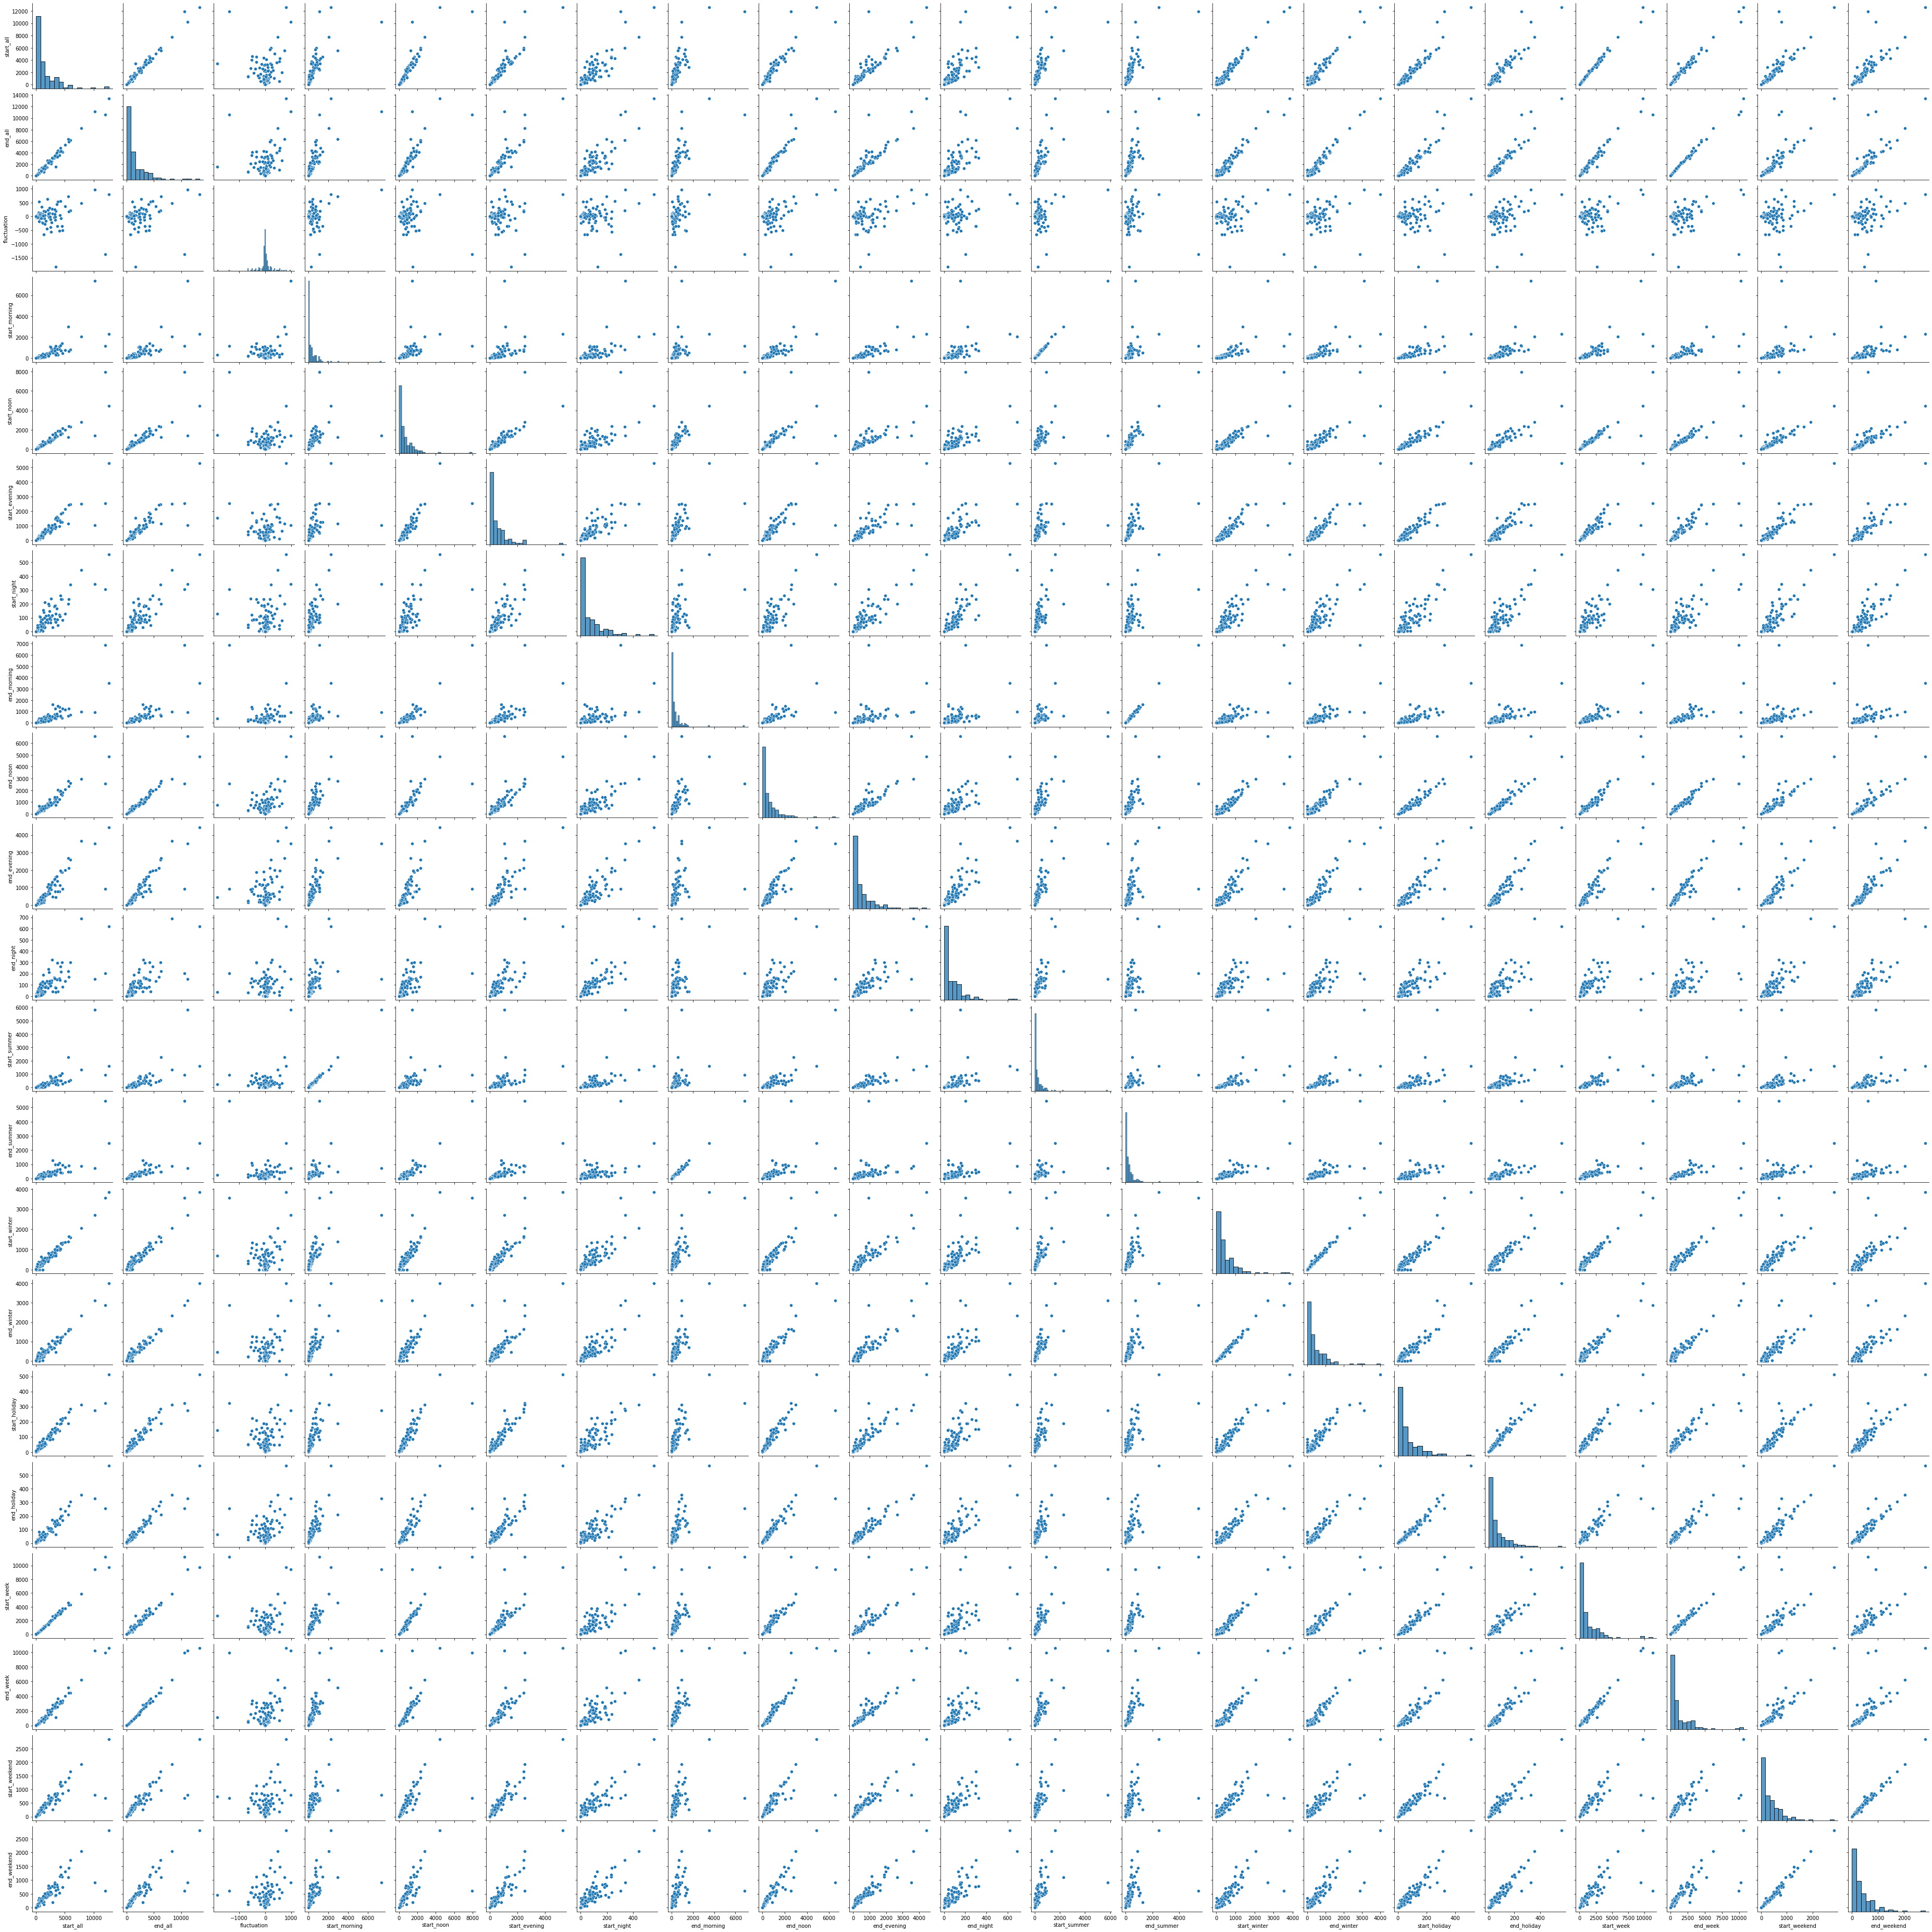

In [10]:
sns.pairplot(data=stations_df)

Looking at the plots the features seem to be linear and we can not distinguish certain groups.

Let us scale the features so the distances we will compute are in the same range.

In [11]:
X = stations_df
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

## PCA Dimensionality Reduction

Because we have 21 features we try to reduce the dimensionality with a principal component analysis. First we try it with 7 components (3 features per component).

In [12]:
pca = PCA(n_components=7)
pca.fit_transform(X_scaled_df)
print(sum(pca.explained_variance_ratio_))

0.9952236035755262


As 99,5% are a very good approximation of our features we look at the variance ratio with even less components:

In [13]:
for i in range (1,7):
    pca = PCA(n_components=i)
    pca.fit_transform(X_scaled_df)
    print(f"with {i} components: ", sum(pca.explained_variance_ratio_))

with 1 components:  0.7850588884144761
with 2 components:  0.8835066918229411
with 3 components:  0.9447343867293274
with 4 components:  0.9758559161609907
with 5 components:  0.9876222640190623
with 6 components:  0.9921023280977793


With these values we choose 4 components because 97,7% are still a very good approximation

In [14]:
pca = PCA(n_components=4)
X_scaled_pca = pca.fit_transform(X_scaled_df)

## Algorithm 1: K-means++

Now we will run the clustering algorithm K-means++ on this data to answer two main questions:
1. Which clusters are found by the algorithm?
2. Are those clusters useful and informative in terms of our business values?

We can use the `KMeans()` Model because scikit learn uses K-means++ by default.

In [15]:
# defining the maximum quantity of centers
k_max = 20

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, )
    model.fit(X_scaled_pca)
    clusters.append(k + 1)
    losses.append(model.inertia_)

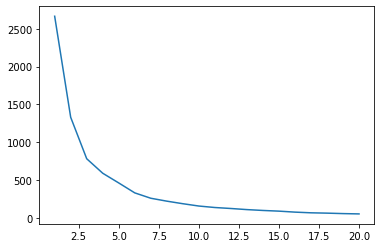

In [16]:
# plot losses
plt.plot(clusters, losses)
plt.show()

(0.0, 7.0)

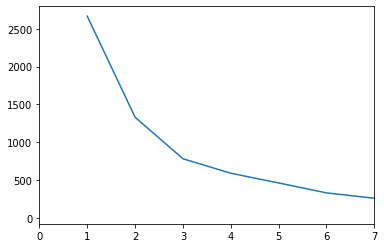

In [17]:
# plot losses more detailed
plt.plot(clusters, losses)
plt.xlim([0, 7])

The hard edge can be seen at k=3. So we will run the model with 3 clusters again and take a closer look. Furthermore we add a random state to our model so it can be recreated with the same cluster-label-numbers.

In [18]:
# run again with k=10
three_means = KMeans(n_clusters=3, random_state=4711)
three_means.fit(X_scaled_pca)
three_means.predict(X_scaled_pca)

array([2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

### 1. Which clusters are found by the algorithm?

Now we will analyse each cluster to label it. To do so we add the clusters to our X dataframe and have look at their sizes at first.

In [19]:
# map cluster to data
X["cluster"] = three_means.labels_
X.groupby(X["cluster"]).size()

cluster
0    92
1    34
2     4
dtype: int64

We can see that only 4 stations are in cluster 2 and most of the stations are in a big cluster altogether. Despite this we will do an analysis on those 3 clusters:

In [20]:
# function for plotting and comparing clusters in different features
def show_cluster_values(columns):
    fig, axs = plt.subplots(int((len(columns)+1)/2),2, squeeze=True)
    fig.set_size_inches(10,10)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(x=X["cluster"], y=X[col], data=X, palette="magma",  ax=axs[plots_row][plots_col])
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()

First we take a look at the quantity of all start and end trips and at different times of the day.

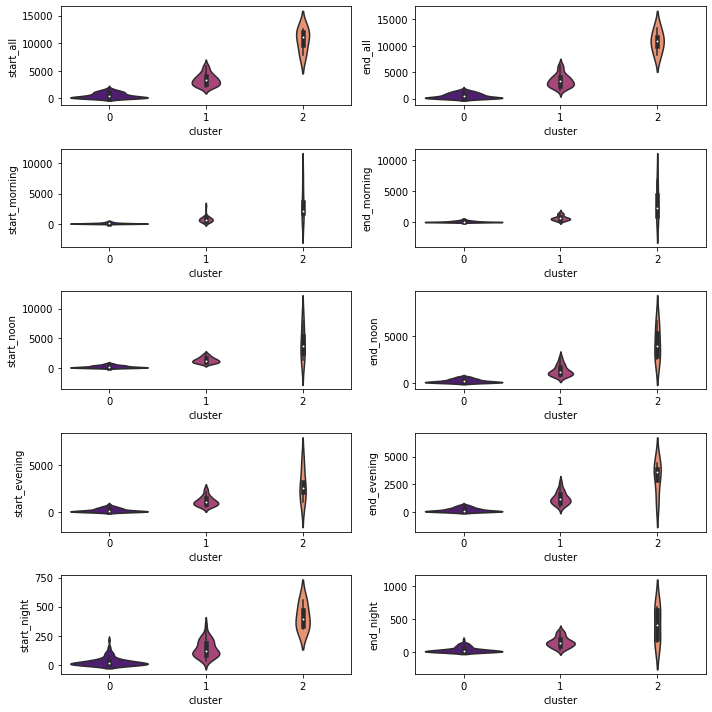

In [21]:
show_cluster_values([
    "start_all","end_all",
    "start_morning","end_morning",
    "start_noon","end_noon",
    "start_evening","end_evening",
    "start_night","end_night",
])

On the left side is the demand for starting at different times and on the right the demand for ending a trip. This is the analysis:
- all: For the whole demand cluster 0 describes the locations with the lowest demand, cluster 2 for a high demand and cluster 1 is in between of 0 and 2.
- different times: Nearly no trips of cluster 0 start in the morning. Every station in cluster 2 has starting trips at night. For cluster 1 the demand ist equally distributed for different times.

Now we want to analyse the demand for different seasons and the fluctuation.

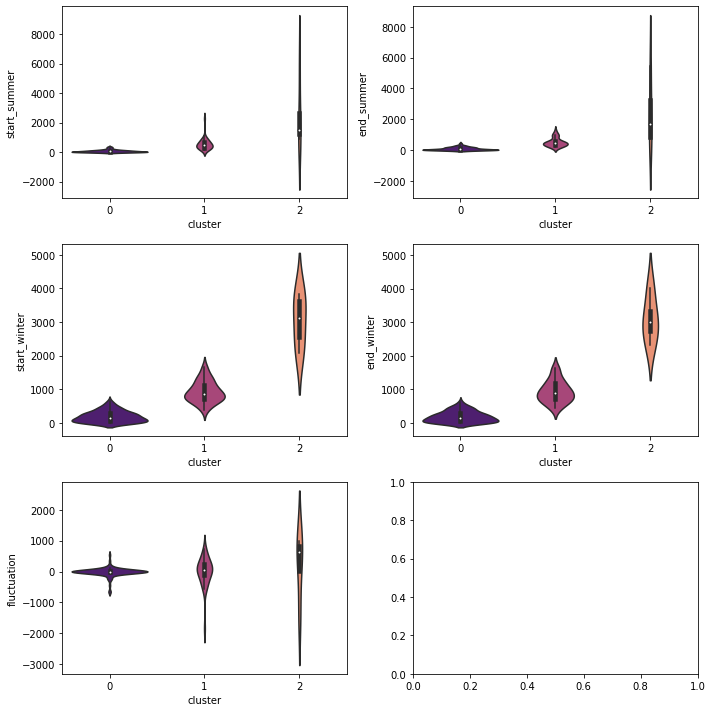

In [22]:
show_cluster_values(
    ["start_summer", "end_summer", "start_winter", "end_winter", "fluctuation"]
)

- summer and winter: In the winter season all stations of cluster 2 are still demanded whereas cluster 0 has many 0-demand stations. In the summer cluster there are also 0-demand stations in cluster 2.
- fluctuation: In cluster 0 the quantity of starting and ending trips are about the same. For cluster 2 there are stations with very high outgoing but low incoming trips and also the other way around. Cluster 1 is rather more starting than ending trips.

Now we will take a look at the weekend, weekday and holiday features

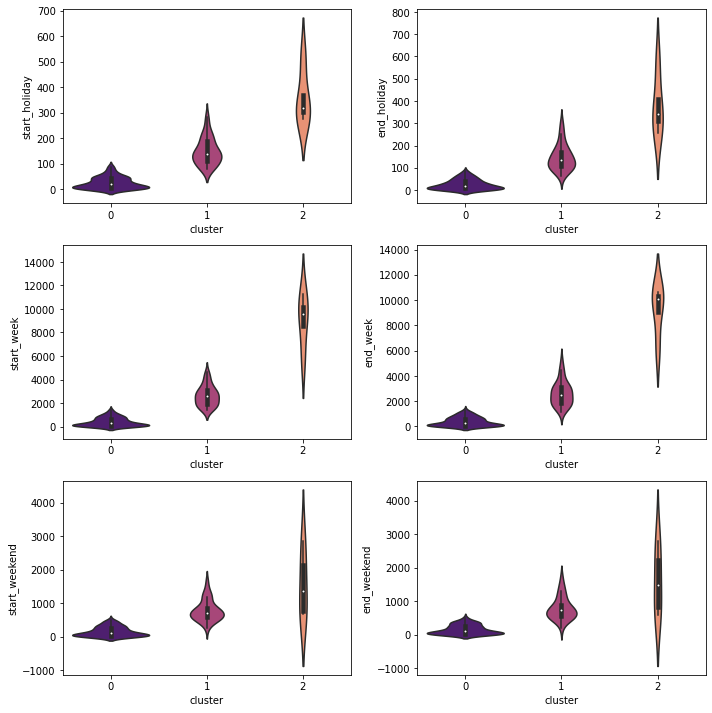

In [23]:
show_cluster_values(
    [
        "start_holiday",
        "end_holiday",
        "start_week",
        "end_week",
        "start_weekend",
        "end_weekend",
    ]
)

- holiday: All stations in cluster 2 have start and end trips on holidays.
- week: All stations in cluster 2 have start and end trips on weekdays.
- weekend: Only on the weekend there are stations in cluster 2 that are not used. The other clusters are equally disrtibuted

If we sum up our findings we can label the clusters as such:
- Cluster 0: very low demand, no morning trips, extreme low demand in winter, fluctuation ~0 - **low demand | no morning**
- Cluster 1: middle demand, more start than end trips - **middle demand | outgoing**
- Cluster 2: very high demand, night stations, demand in winter, high fluctuation, holidays and week - **high demand | high fluct**

In [24]:
labels = [
    "low demand | no morning",
    "middle demand | outgoing",
    "high demand | high fluct"
]
X["label"] = X["cluster"].apply(lambda x: labels[x])
X.head()

,start_all,end_all,fluctuation,start_morning,start_noon,start_evening,start_night,end_morning,end_noon,end_evening,...,start_winter,end_winter,start_holiday,end_holiday,start_week,end_week,start_weekend,end_weekend,cluster,label
start_station_id,,,,,,,,,,,,,,,,,,,,,
3005,12610,13408,798,2289.0,4458.0,5303.0,560.0,3517.0,4846.0,4424,...,3836.0,4004.0,512.0,570.0,9767,10607,2843.0,2801.0,2,high demand | high fluct
3006,5959,6177,218,825.0,2338.0,2457.0,339.0,676.0,2604.0,2598,...,1599.0,1624.0,285.0,306.0,4303,4452,1656.0,1725.0,1,middle demand | outgoing
3007,4608,4110,-498,472.0,2173.0,1881.0,82.0,1261.0,1831.0,935,...,1334.0,1272.0,222.0,168.0,3752,3369,856.0,741.0,1,middle demand | outgoing
3008,3375,3244,-131,390.0,1326.0,1470.0,189.0,744.0,1201.0,1141,...,1025.0,982.0,160.0,136.0,2527,2386,848.0,858.0,1,middle demand | outgoing
3010,721,755,34,33.0,351.0,325.0,12.0,186.0,440.0,116,...,209.0,193.0,40.0,45.0,594,557,127.0,198.0,0,low demand | no morning


### 2. Are those clusters useful and informative in terms of our business values?

For nearly all features the distribution between the clusters is very similar. Because of that we mainly only cluster in high, middle and low demand. This could also be done by distinguishing 1 feature in to 3 parts. So here the clustering does not bring a lot of information for our business value.